# Kalman Filter
https://towardsdatascience.com/exposing-the-power-of-the-kalman-filter-1b78621c3f56 

In [1]:
import numpy as np

class KalmanFilter:
    """
    An implementation of the classic Kalman Filter for linear dynamic systems.
    The Kalman Filter is an optimal recursive data processing algorithm which
    aims to estimate the state of a system from noisy observations.

    Attributes:
        F (np.ndarray): The state transition matrix.
        B (np.ndarray): The control input marix.
        H (np.ndarray): The observation matrix.
        u (np.ndarray): the control input.
        Q (np.ndarray): The process noise covariance matrix.
        R (np.ndarray): The measurement noise covariance matrix.
        x (np.ndarray): The mean state estimate of the previous step (k-1).
        P (np.ndarray): The state covariance of previous step (k-1).
    """
    def __init__(self, F, B, u, H, Q, R, x0, P0):
        """
        Initializes the Kalman Filter with the necessary matrices and initial state.

        Parameters:
            F (np.ndarray): The state transition matrix.
            B (np.ndarray): The control input marix.
            H (np.ndarray): The observation matrix.
            u (np.ndarray): the control input.
            Q (np.ndarray): The process noise covariance matrix.
            R (np.ndarray): The measurement noise covariance matrix.
            x0 (np.ndarray): The initial state estimate.
            P0 (np.ndarray): The initial state covariance matrix.
        """
        self.F = F  # State transition matrix
        self.B = B  # Control input matrix
        self.u = u  # Control vector
        self.H = H  # Observation matrix
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance
        self.x = x0  # Initial state estimate
        self.P = P0  # Initial estimate covariance

    def predict(self):
        """
        Predicts the state and the state covariance for the next time step.
        """
        self.x = self.F @ self.x + self.B @ self.u
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x

    def update(self, z):
        """
        Updates the state estimate with the latest measurement.

        Parameters:
            z (np.ndarray): The measurement at the current step.
        """
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        I = np.eye(self.P.shape[0])
        self.P = (I - K @ self.H) @ self.P
        
        return self.x  #  Challenges with Non-linear Systems

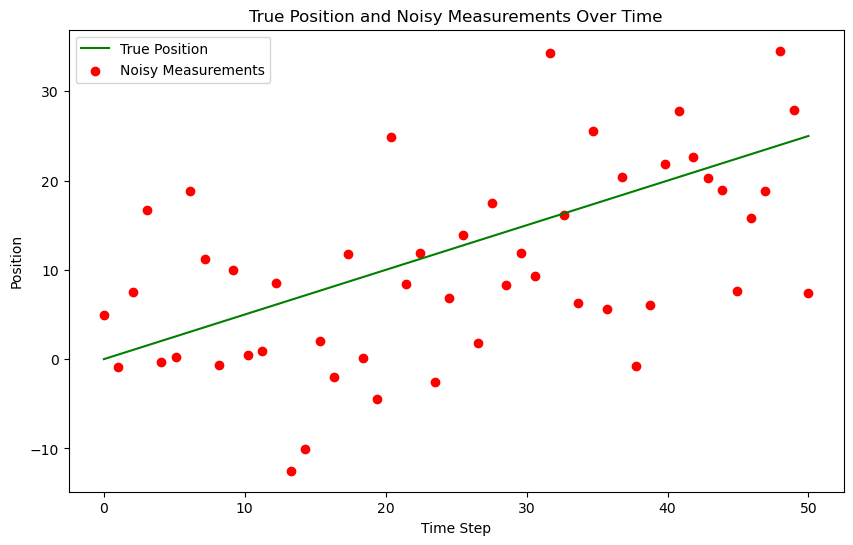

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(42)

# Simulate the ground truth position of the object
true_velocity = 0.5  # units per time step
num_steps = 50
time_steps = np.linspace(0, num_steps, num_steps)
true_positions = true_velocity * time_steps

# Simulate the measurements with noise
measurement_noise = 10  # increase this value to make measurements noisier
noisy_measurements = true_positions + np.random.normal(0, measurement_noise, num_steps)

# Plot the true positions and the noisy measurements
plt.figure(figsize=(10, 6))
plt.plot(time_steps, true_positions, label='True Position', color='green')
plt.scatter(time_steps, noisy_measurements, label='Noisy Measurements', color='red', marker='o')

plt.xlabel('Time Step')
plt.ylabel('Position')
plt.title('True Position and Noisy Measurements Over Time')
plt.legend()
plt.show()

/var/folders/hp/251bnqj90tg6m0gmjs0p2czw0000gn/T/ipykernel_18238/1437121797.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  estimated_positions[t] = kf.x[0]
/var/folders/hp/251bnqj90tg6m0gmjs0p2czw0000gn/T/ipykernel_18238/1437121797.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  estimated_velocities[t] = kf.x[1]


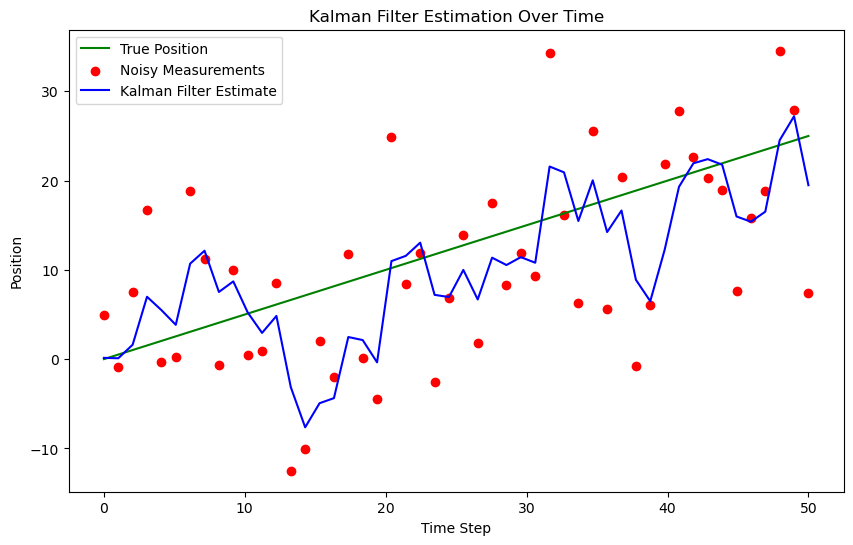

In [3]:
# Kalman Filter Initialization
F = np.array([[1, 1], [0, 1]])   # State transition matrix
B = np.array([[0], [0]])          # No control input
u = np.array([[0]])               # No control input
H = np.array([[1, 0]])            # Measurement function
Q = np.array([[1, 0], [0, 3]])    # Process noise covariance
R = np.array([[measurement_noise**2]]) # Measurement noise covariance
x0 = np.array([[0], [0]])         # Initial state estimate
P0 = np.array([[1, 0], [0, 1]])   # Initial estimate covariance

kf = KalmanFilter(F, B, u, H, Q, R, x0, P0)

# Allocate space for estimated positions and velocities
estimated_positions = np.zeros(num_steps)
estimated_velocities = np.zeros(num_steps)

# Kalman Filter Loop
for t in range(num_steps):
    # Predict
    kf.predict()
    
    # Update
    measurement = np.array([[noisy_measurements[t]]])
    kf.update(measurement)
    
    # Store the filtered position and velocity
    estimated_positions[t] = kf.x[0]
    estimated_velocities[t] = kf.x[1]

# Plot the true positions, noisy measurements, and the Kalman filter estimates
plt.figure(figsize=(10, 6))
plt.plot(time_steps, true_positions, label='True Position', color='green')
plt.scatter(time_steps, noisy_measurements, label='Noisy Measurements', color='red', marker='o')
plt.plot(time_steps, estimated_positions, label='Kalman Filter Estimate', color='blue')

plt.xlabel('Time Step')
plt.ylabel('Position')
plt.title('Kalman Filter Estimation Over Time')
plt.legend()
plt.show()

# Tracking a moving object in 4D

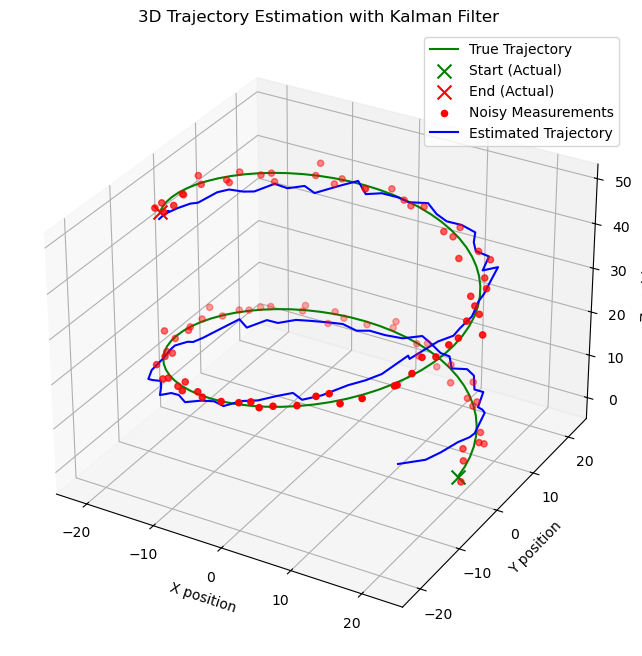

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class KalmanFilter:
    """
    An implementation of the classic Kalman Filter for linear dynamic systems.
    The Kalman Filter is an optimal recursive data processing algorithm which
    aims to estimate the state of a system from noisy observations.

    Attributes:
        F (np.ndarray): The state transition matrix.
        B (np.ndarray): The control input marix.
        H (np.ndarray): The observation matrix.
        u (np.ndarray): the control input.
        Q (np.ndarray): The process noise covariance matrix.
        R (np.ndarray): The measurement noise covariance matrix.
        x (np.ndarray): The mean state estimate of the previous step (k-1).
        P (np.ndarray): The state covariance of previous step (k-1).
    """
    def __init__(self, F=None, B=None, u=None, H=None, Q=None, R=None, x0=None, P0=None):
        """
        Initializes the Kalman Filter with the necessary matrices and initial state.

        Parameters:
            F (np.ndarray): The state transition matrix.
            B (np.ndarray): The control input marix.
            H (np.ndarray): The observation matrix.
            u (np.ndarray): the control input.
            Q (np.ndarray): The process noise covariance matrix.
            R (np.ndarray): The measurement noise covariance matrix.
            x0 (np.ndarray): The initial state estimate.
            P0 (np.ndarray): The initial state covariance matrix.
        """
        self.F = F  # State transition matrix
        self.B = B  # Control input matrix
        self.u = u  # Control input
        self.H = H  # Observation matrix
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance
        self.x = x0  # Initial state estimate
        self.P = P0  # Initial estimate covariance

    def predict(self):
        """
        Predicts the state and the state covariance for the next time step.
        """
        self.x = np.dot(self.F, self.x) + np.dot(self.B, self.u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q

    def update(self, z):
        """
        Updates the state estimate with the latest measurement.

        Parameters:
            z (np.ndarray): The measurement at the current step.
        """
        y = z - np.dot(self.H, self.x)
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  # Kalman Filter matrix
        self.x = self.x + np.dot(K, y)
        self.P = self.P - np.dot(np.dot(K, self.H), self.P)  # "simplified" version: see Alex Becker's book

# Parameters for simulation
true_angular_velocity = 0.1  # radians per time step
radius = 20
num_steps = 100
dt = 1  # time step

# Create time steps
time_steps = np.arange(0, num_steps*dt, dt)

# Ground truth state
true_x_positions = radius * np.cos(true_angular_velocity * time_steps)
true_y_positions = radius * np.sin(true_angular_velocity * time_steps)
true_z_positions = 0.5 * time_steps  # constant velocity in z

# Create noisy measurements
measurement_noise = 1.0
noisy_x_measurements = true_x_positions + np.random.normal(0, measurement_noise, num_steps)
noisy_y_measurements = true_y_positions + np.random.normal(0, measurement_noise, num_steps)
noisy_z_measurements = true_z_positions + np.random.normal(0, measurement_noise, num_steps)

# Kalman Filter initialization
F = np.array([[1, 0, 0, -radius*dt*np.sin(true_angular_velocity*dt)],
              [0, 1, 0, radius*dt*np.cos(true_angular_velocity*dt)],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
B = np.zeros((4, 1))
u = np.zeros((1, 1))
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0]])
Q = np.eye(4) * 0.1  # Small process noise
R = measurement_noise**2 * np.eye(3)  # Measurement noise
x0 = np.array([[0], [radius], [0], [true_angular_velocity]])
P0 = np.eye(4) * 1.0

kf = KalmanFilter(F, B, u, H, Q, R, x0, P0)

# Allocate space for estimated states
estimated_states = np.zeros((num_steps, 4))

# Kalman Filter Loop
for t in range(num_steps):
    # Predict
    kf.predict()
    
    # Update
    z = np.array([[noisy_x_measurements[t]],
                  [noisy_y_measurements[t]],
                  [noisy_z_measurements[t]]])
    kf.update(z)
    
    # Store the state
    estimated_states[t, :] = kf.x.ravel()

# Extract estimated positions
estimated_x_positions = estimated_states[:, 0]
estimated_y_positions = estimated_states[:, 1]
estimated_z_positions = estimated_states[:, 2]

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the true trajectory
ax.plot(true_x_positions, true_y_positions, true_z_positions, label='True Trajectory', color='g')
# Plot the start and end markers for the true trajectory
ax.scatter(true_x_positions[0], true_y_positions[0], true_z_positions[0], label='Start (Actual)', c='green', marker='x', s=100)
ax.scatter(true_x_positions[-1], true_y_positions[-1], true_z_positions[-1], label='End (Actual)', c='red', marker='x', s=100)


# Plot the noisy measurements
ax.scatter(noisy_x_measurements, noisy_y_measurements, noisy_z_measurements, label='Noisy Measurements', color='r')

# Plot the estimated trajectory
ax.plot(estimated_x_positions, estimated_y_positions, estimated_z_positions, label='Estimated Trajectory', color='b')

# Plot settings
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_zlabel('Z position')
ax.set_title('3D Trajectory Estimation with Kalman Filter')
ax.legend()

plt.show()

# The Extended Kalman Filter

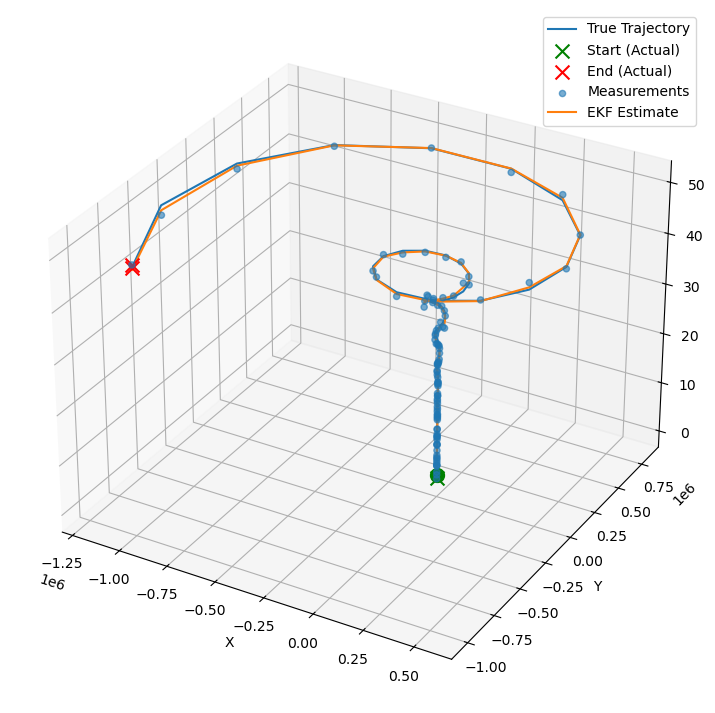

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class ExtendedKalmanFilter:
    """
    An implementation of the Extended Kalman Filter (EKF).
    This filter is suitable for systems with non-linear dynamics by linearising
    the system model at each time step using the Jacobian.
    
    Attributes:
        state_transition (callable): The state transition function for the system.
        jacobian_F (callable): Function to compute the Jacobian of the state transition.
        H (np.ndarray): The observation matrix.
        jacobian_H (callable): Function to compute the Jacobian of the observation model.
        Q (np.ndarray): The process noise covariance matrix.
        R (np.ndarray): The measurement noise covariance matrix.
        x (np.ndarray): The initial state estimate.
        P (np.ndarray): The initial estimate covariance.
    """
    def __init__(self, state_transition, jacobian_F, observation_matrix, jacobian_H, Q, R, x, P):
        """
        Constructs the Extended Kalman Filter.

        Parameters:
            state_transition (callable): The state transition function.
            jacobian_F (callable): Function to compute the Jacobian of F.
            observation_matrix (np.ndarray): Observation matrix.
            jacobian_H (callable): Function to compute the Jacobian of H.
            Q (np.ndarray): Process noise covariance.
            R (np.ndarray): Measurement noise covariance.
            x (np.ndarray): Initial state estimate.
            P (np.ndarray): Initial estimate covariance.
        """
        self.state_transition = state_transition  # Non-linear state transition function
        self.jacobian_F = jacobian_F  # Function to compute Jacobian of F
        self.H = observation_matrix  # Observation matrix
        self.jacobian_H = jacobian_H  # Function to compute Jacobian of H
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance
        self.x = x  # Initial state estimate
        self.P = P  # Initial estimate covariance

    def predict(self, u):
        """
        Predicts the state at the next time step.

        Parameters:
            u (np.ndarray): The control input vector.
        """
        self.x = self.state_transition(self.x, u)
        F = self.jacobian_F(self.x, u)
        self.P = F @ self.P @ F.T + self.Q

    def update(self, z):
        """
        Updates the state estimate with a new measurement.

        Parameters:
            z (np.ndarray): The measurement vector.
        """
        H = self.jacobian_H()
        y = z - self.H @ self.x
        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(len(self.x)) - K @ H) @ self.P

# Define the non-linear transition and Jacobian functions
def state_transition(x, u):
    """
    Defines the state transition function for the system with non-linear dynamics.

    Parameters:
        x (np.ndarray): The current state vector.
        u (np.ndarray): The control input vector containing time step and rate of change of angular velocity.

    Returns:
        np.ndarray: The next state vector as predicted by the state transition function.
    """
    dt = u[0]
    alpha = u[1]
    x_next = np.array([
        x[0] - x[3] * x[1] * dt,
        x[1] + x[3] * x[0] * dt,
        x[2] + x[3] * dt,
        x[3],
        x[4] + alpha * dt
    ])
    return x_next

def jacobian_F(x, u):
    """
    Computes the Jacobian matrix of the state transition function.

    Parameters:
        x (np.ndarray): The current state vector.
        u (np.ndarray): The control input vector containing time step and rate of change of angular velocity.

    Returns:
        np.ndarray: The Jacobian matrix of the state transition function at the current state.
    """
    dt = u[0]
    # Compute the Jacobian matrix of the state transition function
    F = np.array([
        [1, -x[3]*dt, 0, -x[1]*dt, 0],
        [x[3]*dt, 1, 0, x[0]*dt, 0],
        [0, 0, 1, dt, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]
    ])
    return F

def jacobian_H():
    # Jacobian matrix for the observation function is simply the observation matrix
    return H

# Simulation parameters
num_steps = 100
dt = 1.0
alpha = 0.01  # Rate of change of angular velocity

# Observation matrix, assuming we can directly observe the x, y, and z position
H = np.eye(3, 5)

# Process noise covariance matrix
Q = np.diag([0.1, 0.1, 0.1, 0.1, 0.01])

# Measurement noise covariance matrix
R = np.diag([0.5, 0.5, 0.5])

# Initial state estimate and covariance
x0 = np.array([0, 20, 0, 0.5, 0.1])  # [x, y, z, v, omega]
P0 = np.eye(5)

# Instantiate the EKF
ekf = ExtendedKalmanFilter(state_transition, jacobian_F, H, jacobian_H, Q, R, x0, P0)

# Generate true trajectory and measurements
true_states = []
measurements = []
for t in range(num_steps):
    u = np.array([dt, alpha])
    true_state = state_transition(x0, u)  # This would be your true system model
    true_states.append(true_state)
    measurement = true_state[:3] + np.random.multivariate_normal(np.zeros(3), R)  # Simulate measurement noise
    measurements.append(measurement)
    x0 = true_state  # Update the true state

# Now we run the EKF over the measurements
estimated_states = []
for z in measurements:
    ekf.predict(u=np.array([dt, alpha]))
    ekf.update(z=np.array(z))
    estimated_states.append(ekf.x)

# Convert lists to arrays for plotting
true_states = np.array(true_states)
measurements = np.array(measurements)
estimated_states = np.array(estimated_states)

# Plotting the results
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot the true trajectory
ax.plot(true_states[:, 0], true_states[:, 1], true_states[:, 2], label='True Trajectory')
# Increase the size of the start and end markers for the true trajectory
ax.scatter(true_states[0, 0], true_states[0, 1], true_states[0, 2], label='Start (Actual)', c='green', marker='x', s=100)
ax.scatter(true_states[-1, 0], true_states[-1, 1], true_states[-1, 2], label='End (Actual)', c='red', marker='x', s=100)

# Plot the measurements
ax.scatter(measurements[:, 0], measurements[:, 1], measurements[:, 2], label='Measurements', alpha=0.6)
# Plot the start and end markers for the measurements
ax.scatter(measurements[0, 0], measurements[0, 1], measurements[0, 2], c='green', marker='o', s=100)
ax.scatter(measurements[-1, 0], measurements[-1, 1], measurements[-1, 2], c='red', marker='x', s=100)

# Plot the EKF estimate
ax.plot(estimated_states[:, 0], estimated_states[:, 1], estimated_states[:, 2], label='EKF Estimate')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()

In [3]:
16/20 * 15/19 * 14/18 * 13/17 * 12/16 * 11/15 * 10/14 * 9/13 * 8/12 * 7/11

0.04334365325077399

# AZ: Some pieces while reading Kalman Filter from the Ground Up

i: 0 iter: 1 K: 1.00
i: 1 iter: 2 K: 1.00 0.90
i: 2 iter: 3 K: 1.00 0.90 0.47
i: 3 iter: 4 K: 1.00 0.90 0.47 0.32
i: 4 iter: 5 K: 1.00 0.90 0.47 0.32 0.24
i: 5 iter: 6 K: 1.00 0.90 0.47 0.32 0.24 0.20
i: 6 iter: 7 K: 1.00 0.90 0.47 0.32 0.24 0.20 0.16
i: 7 iter: 8 K: 1.00 0.90 0.47 0.32 0.24 0.20 0.16 0.14
i: 8 iter: 9 K: 1.00 0.90 0.47 0.32 0.24 0.20 0.16 0.14 0.12
i: 9 iter: 10 K: 1.00 0.90 0.47 0.32 0.24 0.20 0.16 0.14 0.12 0.11
measurement: 49.03 48.44 55.21 49.98 50.60 52.61 45.87 42.64 48.26 55.84
x_estimate: 60.00 50.13 49.33 51.22 50.92 50.86 51.14 50.40 49.44 49.31 49.96
p_estimate: 225.00 22.50 11.84 8.04 6.08 4.89 4.09 3.52 3.08 2.74 2.47


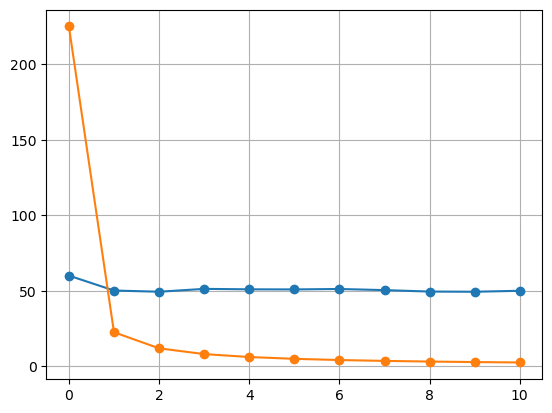

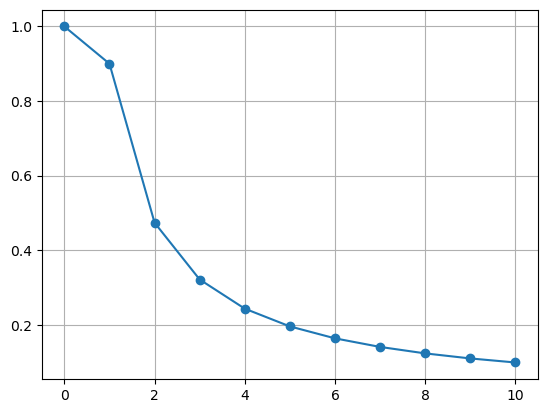

In [19]:
import matplotlib.pyplot as plt

measurement = [49.03, 48.44, 55.21, 49.98, 50.6, 52.61, 45.87, 42.64, 48.26, 55.84]

x00 = 60.
p00 = 15.**2

r = 5.**2  # variance of measurement, does not change

K = [1]
x_predict  = [0]
x_estimate = [x00]
p_estimate = [p00]

for i in range(len(measurement)):
    iter = i + 1
    print('i:', i, 'iter:', iter, 'K:', *[f'{x:0.2f}' for x in K])

    K_n = p_estimate[i] / (p_estimate[i] + r)
    K.append(K_n)

    p_estimate.append( (1 - K[iter]) * p_estimate[i] )
    x_estimate.append( x_estimate[i] + K[iter] * (measurement[i] - x_estimate[i]) )
    x_predict.append( x_estimate[iter] )  # static model

print('measurement:', *[f'{x:0.2f}' for x in measurement])
print('x_estimate:', *[f'{x:0.2f}' for x in x_estimate])
print('p_estimate:', *[f'{x:0.2f}' for x in p_estimate])

plt.figure()
plt.plot(x_estimate, 'o-')
plt.plot(p_estimate, 'o-')
plt.grid()

plt.figure()
plt.plot(K, 'o-')
plt.grid()

In [22]:
import numpy as np

x = np.array([2, 3, -1, 4])
y = np.array([8, 7, 9, 6])

C = np.cov(x, y)
print(f'Covariance matrix np.cov(x, y):\n{C}')

print(f'\nCalculate covariance (off-diagonal element) by-hand\n')

scalar_product = 0

Covariance matrix np.cov(x, y):
[[ 4.66666667 -2.66666667]
 [-2.66666667  1.66666667]]


In [32]:
import numpy as np

x = np.array([2, 3, -1, 4]).reshape((-1, 1))
y = np.array([8, 7, 9, 6]).reshape((-1, 1))

C = np.cov(x.flatten(), y.flatten())              # x and y need to be flattened
print(f'Covariance matrix np.cov(x, y):\n{C}')

print(f'\nCalculate covariance (off-diagonal element) by-hand\n')

scalar_product = x.T @ y
print(f'scalar_product = {scalar_product}')

print(2*8 + 3*7 -1*9 + 4*6)

print(f'\nExtract a single element from dot-product matrix')
print(f'np.dot(x.T, y): {np.dot(x.T, y)}')
print(f'np.dot(x.T, y).item(): {np.dot(x.T, y).item()}')

Covariance matrix np.cov(x, y):
[[ 4.66666667 -2.66666667]
 [-2.66666667  1.66666667]]

Calculate covariance (off-diagonal element) by-hand

scalar_product = [[52]]
52

Extract a single element from dot-product matrix
np.dot(x.T, y): [[52]]
np.dot(x.T, y).item(): 52


In [33]:
x = np.array([2, 3, -1, 4])
y = np.array([8, 7, 9, 6])

np.dot(x, y)

52

# Multivariate Kalman Filter Example 1

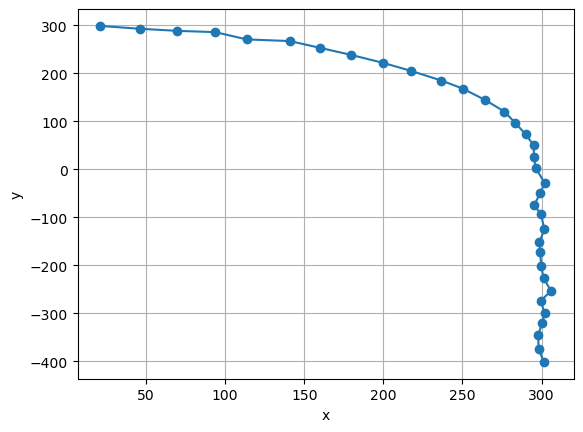

In [36]:
x = [
    301.5, 298.23, 297.83, 300.42, 301.94, 299.5, 305.98, 301.25,
    299.73, 299.2, 298.62, 301.84, 299.6, 295.3, 299.3, 301.95, 296.3,
    295.11, 295.12, 289.9, 283.51, 276.42, 264.22, 250.25, 236.66, 217.47,
    199.75, 179.7, 160, 140.92, 113.53, 93.68, 69.71, 45.93, 20.87
]

y = [
    -401.46,-375.44,-346.15,-320.2,-300.08,-274.12,-253.45,-226.4,
    -200.65,-171.62,-152.11,-125.19,-93.4,-74.79,-49.12,-28.73,2.99,
    25.65,49.86,72.87,96.34,120.4,144.69,168.06,184.99,205.11,
    221.82,238.3,253.02,267.19,270.71,285.86,288.48,292.9,298.77
]

plt.figure()
plt.plot(x, y, 'o-')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()